initialized model_states with 100 sheep and 10 wolves
initialized stores with [100] sheep and (len: 1) wolves
step 0
s: 100
agents_w count: 10
net_agents_w_change: 1
accumulated_dw_remainder: 0
reference ODE: s    100.0
w     10.0
Name: 0, dtype: float64
step 1
s: 99.96
agents_w count: 11
net_agents_w_change: 1
accumulated_dw_remainder: 0.20000000000000018
reference ODE: s    99.874909
w    11.275624
Name: 1, dtype: float64
step 2
s: 99.71609759999998
agents_w count: 12
net_agents_w_change: 1
accumulated_dw_remainder: 0.5193400000000004
reference ODE: s    99.480063
w    12.709054
Name: 2, dtype: float64
step 3
s: 99.26936948275198
agents_w count: 13
net_agents_w_change: 2
accumulated_dw_remainder: 0.9542297568000002
reference ODE: s    98.786165
w    14.313060
Name: 3, dtype: float64
step 4
s: 98.62213319372445
agents_w count: 15
net_agents_w_change: 2
accumulated_dw_remainder: 0.4999824617136639
reference ODE: s    97.764977
w    16.098819
Name: 4, dtype: float64
step 5
s: 97.5767385

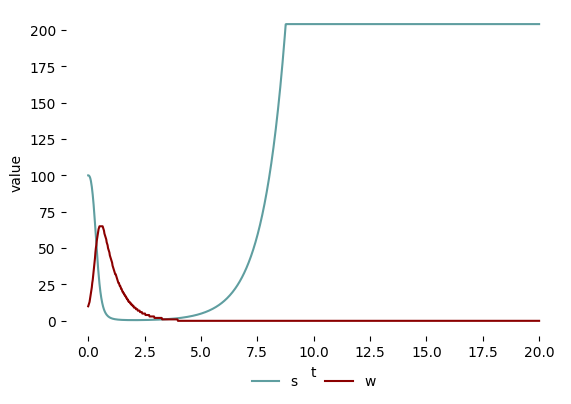

In [41]:
# subliminal wolf ABM: this time it's personal
# v0.1.0

# Same setup but with price-sensitive wolves
import seaborn as sns
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from scipy.integrate import odeint

# throttle
throttle = 100

# Not converting sheep from the ODE for now
model_params = {
    'alpha': 1,
    'beta': 0.1, # we need this at the model level only for the reference ODE
    'gamma': 1.5, # we need this at the model level only for the reference ODE
    'delta': .75, # we need this at the model level only for the reference ODE
    's_start': 100,
    'w_start': 10,
    'dt': .02, 
    's_max': 200  # a convenience param just for model sanity. if the sheep are this many, the wolves have been dead awhile.
    # 'eps': 1e-6 # not currently used
}

model_state = {
    'step_accumulated_ds': None,
    'step_accumulated_dw': None,
    'accumulated_dw_remainder': None, # re-initialize? for now, no.
    's_state': None,
    'agents_w_state': None
}

# time params.
model_time = {
    'tmax': 1000, # "steps" or "ticks"
    'time': None # will be computed from tmax and dt
}
    
#############################################################
# Agent Functions
#############################################################

def instanitate_agent_w(model_params): # note these are model params only due to the ODE reference
    # it would be reasonable to even call these "agent_params" and name like w_beta. we avoid
    # this for now, but it might be a good idea.
    return (
        model_params['beta'],
        model_params['gamma'],
        model_params['delta']
    )

def process_agent_step_w(agent_w, model_params, model_state):
    # process_agent_step reads the state of the agent, the state of the model. since this agent is not mutable
    # (it probably cannot be if we deterministically migrate from an ODE)
    # the agent can only operate on the state of the model.
    # as such, this function outputs accumulated changes to s and agents_w in an approach that
    # approximates the ODE.

    # unpack
    dt = model_params['dt']

    s = model_state['s_state']
    current_step_accumulated_dw = model_state['step_accumulated_dw']
    current_step_accumulated_ds = model_state['step_accumulated_ds']

    w_beta, w_gamma, w_delta = agent_w

    #### original notes
    # for now, i am leaving in quite a bit of commentary.
    # we cannot just eat sheep here. if we do, it is impossible for us to simulate the effects
    # that are seen in the ODE. there are a number of possible workarounds, some of which i dicuss below

    # wolf eats sheep based on same formula, just individualized.
    # ds_dt = alpha * s - beta * s * w
    # dw_dt = -gamma * w + delta * beta * s * w
    # we are definitely going to run into a data chunkiness difference here.
    
    # recapitulated wolf function from the ODE
    dw_dt = (
        -1
        * w_gamma # gamma
        * 1       # this here wolf
        + w_delta # delta
        * w_beta # beta
        * s       # sheep
        * 1       # this here wolf
        )

    #### original notes
    #  let's look at this really closely under the lens of 
    # model variables and agent variables

    # we effectively need to process changes that affect other *agents*.
    # there are two primary ways to do this:
    # we could have a model-level variable that is basically wolf_agent_count
    # this seems possibly effective but the problem is that technically a model-level var
    # should only interact on agents individually
    # in other words we would need some "wolf pressure" and a function.
    # not necessarily a hack if we formally tie it back to the ODE!

    # we can of course also affect other agents directly
    # with the output from this function.
    ####

    # for now our approach is to have the model-level accumulation of changes to state.
    # interestingly, these accumulations are intrastep, since all the wolves process at once.
    # however, taking this approach allows us to stick to the idea that the agent itself is responsible for effecting change
    # at the step runtime. in other words, it keeps the agent "doing" something.

    added_dw = dw_dt * dt # scale to dt!
    model_state['step_accumulated_dw'] = added_dw + current_step_accumulated_dw

    # calculate the change in sheep using ONLY the contibution from THIS wolf

    ds_dt_one_w_only = - w_beta * s
    model_state['step_accumulated_ds'] = ds_dt_one_w_only * dt + current_step_accumulated_ds

    return model_state
    
#################################################################
# Model Functions
#################################################################
# Make all w_start wolves
def initialize_agents_w(w_start):
    agents_w = []
    for i in range(w_start):
        agents_w.append(instanitate_agent_w(model_params))
    return agents_w

def reset_accumulators(model_state, t):
    model_state['step_accumulated_dw'] = 0
    model_state['step_accumulated_ds'] = 0
    return model_state

def process_agents_step(model_params, model_state, t):
    # this function will process all agents sychronously and return the new state of the model
    agents_w = model_state['agents_w_state']
    for agent_w in agents_w:
        model_state = process_agent_step_w(agent_w, model_params, model_state)

    return model_state

def ODE_accumulate_and_fit(model_state, t): # TODO think about this name
    # this function will need some attention, but the primary goal here is to accumulate the actions of individual agents
    # and then use them to create a smoother model-wide change.
    # there is a TON of formalism needed here, i believe
    ds_total = model_state['step_accumulated_ds']
    dw_total = model_state['step_accumulated_dw']
    accumulated_dw_remainder = model_state['accumulated_dw_remainder']

    # add the acc_dw_r into the dw_total
    dw_total += accumulated_dw_remainder # don't forget to account later

    # Apply ds_total to sheep
    new_s = model_state['s_state'] + ds_total
    new_s_or_zero = max(0, new_s)  # no negative sheep
    new_s_or_max = min(new_s_or_zero, model_params['s_max'])
    model_state['s_state'] = new_s_or_max

    # Convert dw_total to integer wolf births/deaths
    agents_w = model_state['agents_w_state']
    # compute the step change but save the remainder
    net_agents_w_change = int(dw_total) 
    print_if_throttle(f"net_agents_w_change: {net_agents_w_change}", t)
    new_remainder = dw_total - net_agents_w_change
    print_if_throttle(f"accumulated_dw_remainder: {accumulated_dw_remainder}", t)
    # still need to move rounding chunks into remainder bins
    if net_agents_w_change > 0:
        for _ in range(net_agents_w_change):
            agents_w.append(instanitate_agent_w(model_params))
    elif net_agents_w_change < 0:
        # remove that many wolves from the end
        remove_count = min(len(agents_w), abs(net_agents_w_change))
        for _ in range(remove_count):
            agents_w.pop()

    model_state['agents_w_state'] = agents_w
    model_state['accumulated_dw_remainder'] = new_remainder

    # Optional correction (eps)

    # eps = model_params.get('eps', 0.0)
    # TODO, this would be an upportunity to push off of zeros
    # right now, when the wolves die, they are dead.
    # e.g. model_state['s_state'] = un_zero() ...

    return model_state

def process_s_euler_forward(model_params, model_state, t):
    # unpack
    alpha = model_params['alpha']
    s = model_state['s_state']
    # this model function operates on the model-level population of sheep, and model variables for sheep
    ds_dt = (
        (
            alpha    # model, not agent, variable; operates population-wide   
            * s        # sheep count
        )
    )
    # send value with which to update model_level sheep variable
    # don't go below zero
    new_s = max(0, s + ds_dt * model_params['dt'])
    model_state['s_state'] = new_s
    return model_state

def process_model_step(model_params, model_state, t):
    # agents move first, arbitrary
    model_state = reset_accumulators(model_state, t)
    model_state = process_agents_step(model_params, model_state, t)
    model_state = ODE_accumulate_and_fit(model_state, t)
    model_state = process_s_euler_forward(model_params, model_state, t)
    return model_state

#################################################################
# Utility Functions
#################################################################

# for reference ODE only
def dx_dt(x, t, alpha, beta, gamma, delta):
    s, w = x
    ds_dt = alpha * s - beta * s * w
    dw_dt = -gamma * w + delta * beta * s * w
    return [ds_dt, dw_dt]

def get_reference_ODE(model_params, model_time):
    alpha = model_params['alpha']
    beta = model_params['beta']
    gamma = model_params['gamma']
    delta = model_params['delta']
    
    t_end = model_time['time']
    times = np.linspace(0, t_end, model_time['tmax'])

    # initial conditions
    x0 = [model_params['s_start'], model_params['w_start']]

    # solve
    integration = odeint(dx_dt, x0, times, args=(alpha, beta, gamma, delta)) # via cursor, verify this
    # Convert to DataFrame
    ode_df = pd.DataFrame({
        't': times,
        's': integration[:,0],
        'w': integration[:,1]
    })
    return ode_df

def print_if_throttle(stmt, t):
    # Print all statements for t < 10
    if t < 10:
        print(stmt)
        return
        
    # For t >= 10, only print when t is a power of 10, 
    # dorky but it works! (eh, actually, does it? probably should reverse midflight)
    log10_t = int(np.log10(t))
    if t % (10 ** log10_t) == 0:
        print(stmt)
    return
#################################################################
# The Model
#################################################################   

# Simulate with wolves
def run_agent_based_model(model_params, model_state, model_time):
    # model implementation of time
    model_time['time'] = model_time['tmax'] * model_params['dt']

    # unpack model params
    model_state = {
        's_state': model_params['s_start'],
        'agents_w_state': initialize_agents_w(model_params['w_start']),
        'step_accumulated_dw': 0,
        'step_accumulated_ds': 0,
        'accumulated_dw_remainder': 0
    }
    # unpack dt
    dt = model_params['dt']

    print(f"initialized model_states with {model_state['s_state']} sheep and {len(model_state['agents_w_state'])} wolves")
    # the stores record model functioning over time. initialize them using model state.
    # individual stores since one contains lists.
    s_store = [model_params['s_start']]
    agents_w_store = []
    agents_w_store = [model_state['agents_w_state'][:]]  # Shallow copy is fine for immutable tuples
    t_store = [0]

    print(f"initialized stores with {s_store} sheep and (len: {len(agents_w_store)}) wolves")

    # reference ODE. for now we just put it in memory.
    reference_ODE = get_reference_ODE(model_params, model_time)

    # iterate over steps
    for t in range(model_time['tmax']):
        print_if_throttle(f'step {t}', t)
        print_if_throttle(f's: {model_state["s_state"]}', t)
        print_if_throttle(f'agents_w count: {len(model_state["agents_w_state"])}', t)

        # process model step
        # note that our model processing doesn't need the step number; just dt
        model_state = process_model_step(model_params, model_state, t)
    
        # make a record in the stores
        s_store.append(model_state['s_state'])
        agents_w_store.append(model_state['agents_w_state'][:])  # Store a copy of the current agents list
        t_store.append(t_store[-1] + dt)

        # print the appropriate timepoint from the reference ODE
        print_if_throttle(f"reference ODE: {reference_ODE.loc[t, ['s', 'w']]}", t)

    # Generate a model return
    xdf = pd.DataFrame({
        's': s_store, 
        'w': [len(agent_list) for agent_list in agents_w_store],  # Convert each list of agents to count
        't': t_store
    })

    return xdf

#################################################################
# Notebook Work
#################################################################

# Run the model
xdf = run_agent_based_model(model_params, model_state, model_time)

# Plot the stabilized system
sns.lineplot(pd.melt(xdf, id_vars=['t']), x = 't', y = 'value', hue = 'variable', palette=['cadetblue', 'darkred'])
plt.legend(frameon = False, ncol = 2, loc='lower center', bbox_to_anchor=(.5, -.2))
sns.despine(left = True, bottom = True)
plt.subplots_adjust(bottom=0.2)
#plt.savefig('hungry-like-an-agent_LVtimeseries.pdf')